# langevin matching
we suggest looking at the notes for an explanation of this method.

In [1]:
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

### gaussian framework
our unknown data really comes from a gaussian, $\mu_g \sim \mathcal{N}(-10, 1)$.
we use the family of gaussians with variance one to model it. in this setting $\theta$ is our current mean. we start with $\theta = 10$.

In [2]:
# single langevin step, for a single particle
def langevin_step_particle(x, theta, eps, key):
    noise = jax.random.normal(key, shape=x.shape)
    grad = x - theta  # gradient of the potential
    return x - eps * grad + jnp.sqrt(2 * eps) * noise

In [3]:
# batch evolution via langevin diffusion
def langevin_evolve_batch(x0_batch, theta, eps, keys_batch, n_steps):
    x = x0_batch
    for t in range(n_steps):
        keys_t = keys_batch[:, t]
        x = jax.vmap(langevin_step_particle, in_axes=(0, None, None, 0))(x, theta, eps, keys_t)

    # plot initial kde and evolved kde for each iteration, mod. something

    x0_np = np.array(x0_batch)
    xT_np = np.array(x)

    kde_x0 = gaussian_kde(x0_np)
    kde_xT = gaussian_kde(xT_np)
    x_grid = np.linspace(min(x0_np.min(), xT_np.min()) - 1,
                        max(x0_np.max(), xT_np.max()) + 1, 500)

    plt.figure(figsize=(6, 4))
    plt.plot(x_grid, kde_x0(x_grid), label='start $x_0$', lw=2)
    plt.plot(x_grid, kde_xT(x_grid), label='evolved $x_T$', lw=2)
    plt.title(f'theta = {float(theta):.2f}')
    plt.xlabel("x")
    plt.ylabel("density kde")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return x

# same without any plots
def langevin_evolve_batch_no_plot(x0_batch, theta, eps, keys_batch, n_steps):
    x = x0_batch
    for t in range(n_steps):
        keys_t = keys_batch[:, t]
        x = jax.vmap(langevin_step_particle, in_axes=(0, None, None, 0))(x, theta, eps, keys_t)
    return x


In [4]:
# definition of loss function
def loss_fn(theta, x0_batch, eps, keys_batch, n_steps):
    xT = langevin_evolve_batch_no_plot(x0_batch, theta, eps, keys_batch, n_steps)
    return jnp.mean((jnp.sort(xT) - jnp.sort(x0_batch))**2)

# training
def train_langevin_matching(
    n_particles=500,
    n_steps=200,
    n_iter=100,
    eps=1e-2,
    lr=1e-1,
    seed=0
):
    key = jax.random.PRNGKey(seed)
    key, key_x0 = jax.random.split(key)
    x0 = jax.random.normal(key_x0, shape=(n_particles,)) - 10.0  # sample from real measure

    theta = jnp.array(10.0)  # starting theta
    opt = optax.adam(lr)
    opt_state = opt.init(theta)
    losses = []

    for epoch in range(n_iter):
        # generate keys
        key, subkey = jax.random.split(key)
        keys_flat = jax.random.split(subkey, n_particles * n_steps)
        keys_batch = keys_flat.reshape((n_particles, n_steps, 2))

        # loss and gradient
        loss_val, grad_val = jax.value_and_grad(loss_fn)(theta, x0, eps, keys_batch, n_steps)

        # updating theta
        updates, opt_state = opt.update(grad_val, opt_state)
        theta = optax.apply_updates(theta, updates)

        # plots
        if epoch%10 == 0:
            print(f"Epoch {epoch:3d} | theta = {theta:.4f} | grad = {grad_val:.4f} | loss = {loss_val:.4f}")
            xT = langevin_evolve_batch(x0, theta, eps, keys_batch, n_steps)
            losses.append(loss_val.item())

    # final plot for the losses
    plt.figure(figsize=(6, 4))
    plt.plot(losses, lw=2)
    plt.xlabel("Epoca")
    plt.ylabel("Loss (MSE tra sample ordinati)")
    plt.title("Andamento della Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return theta, losses

Epoch   0 | theta = 9.5000 | grad = 30.2580 | loss = 305.1960


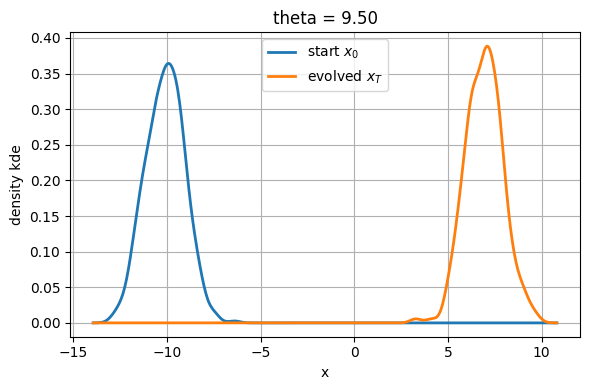

Epoch  10 | theta = 4.5654 | grad = 22.7699 | loss = 172.8306


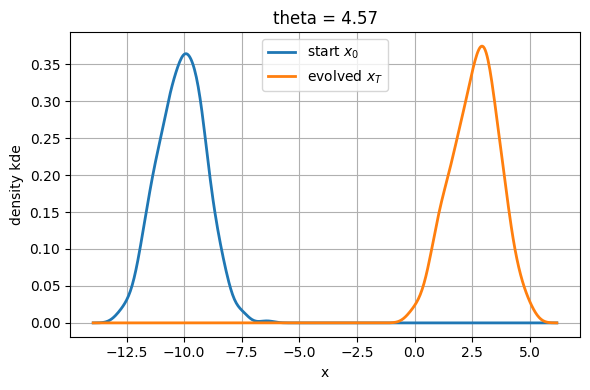

Epoch  20 | theta = -0.0357 | grad = 15.8727 | loss = 83.9868


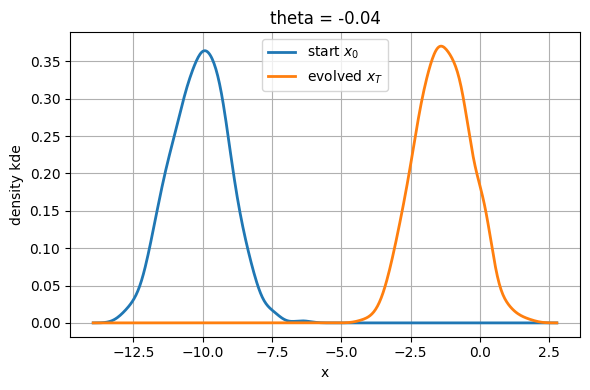

Epoch  30 | theta = -3.9869 | grad = 9.6425 | loss = 30.9997


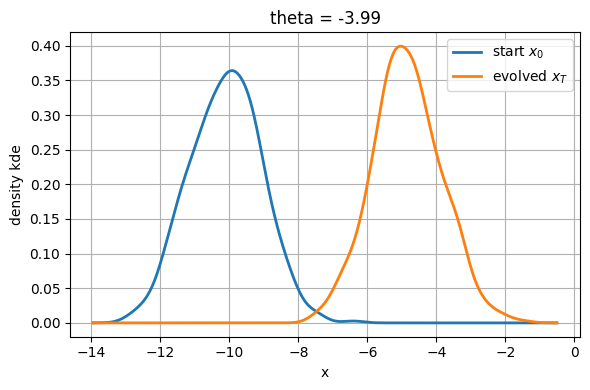

Epoch  40 | theta = -7.0302 | grad = 5.0771 | loss = 8.5955


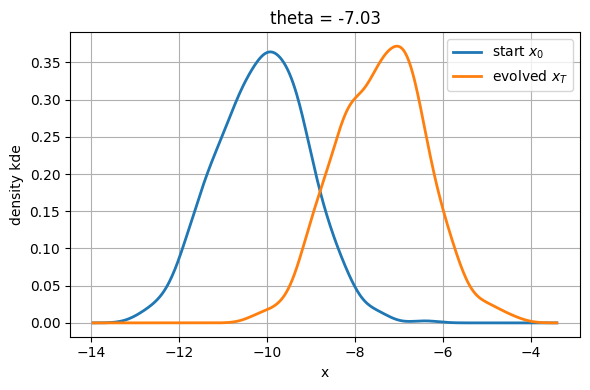

Epoch  50 | theta = -9.0585 | grad = 1.9307 | loss = 1.2469


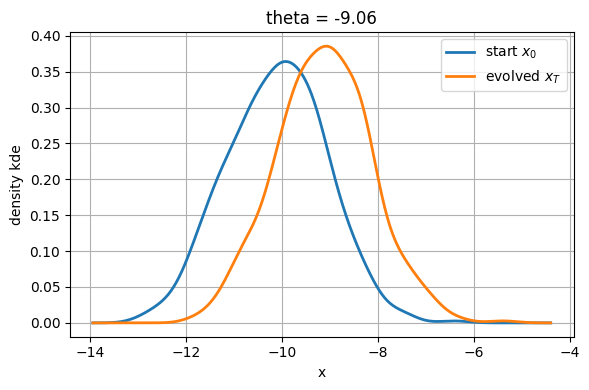

Epoch  60 | theta = -10.1573 | grad = 0.0181 | loss = 0.0074


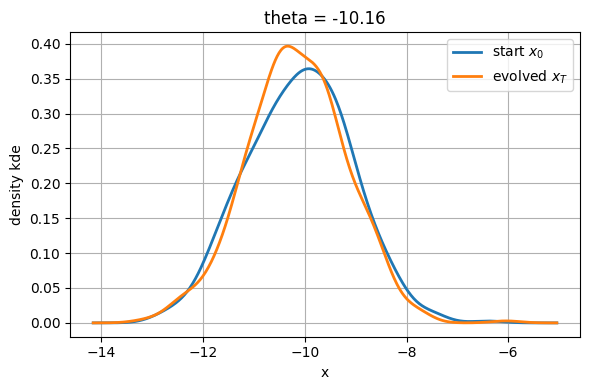

Epoch  70 | theta = -10.5576 | grad = -0.7659 | loss = 0.2016


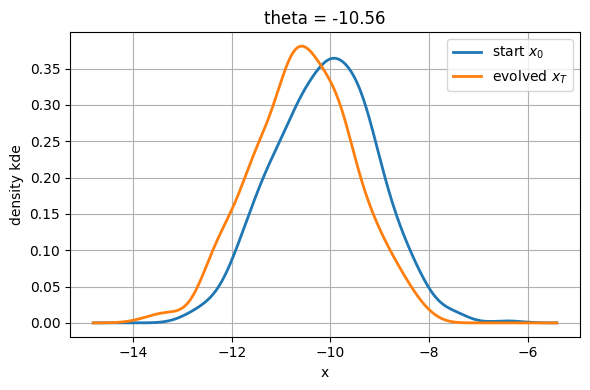

Epoch  80 | theta = -10.5448 | grad = -0.7506 | loss = 0.1954


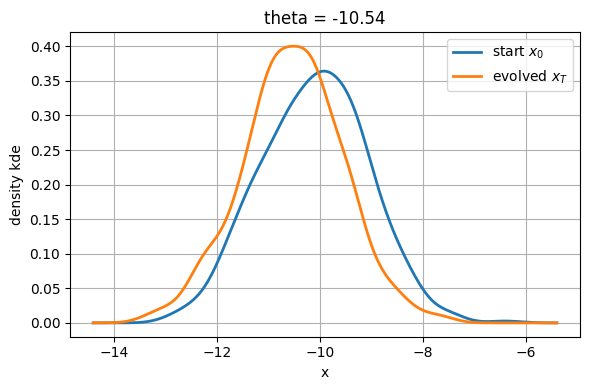

Epoch  90 | theta = -10.3696 | grad = -0.3968 | loss = 0.0593


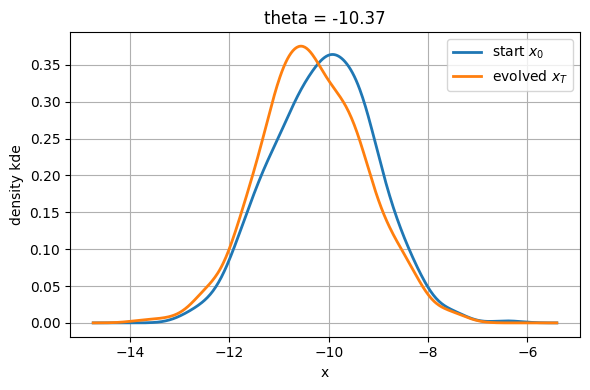

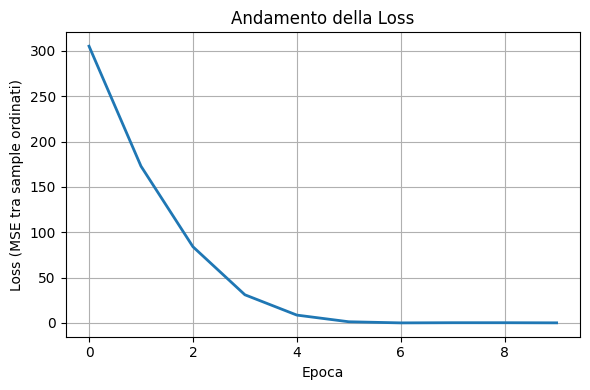

In [5]:
final_theta, losses = train_langevin_matching(  n_particles=500, 
                                                n_steps=200,
                                                n_iter=100,
                                                eps=1e-2,
                                                lr=0.5,
                                                seed=0  )